# 데이터 불러오기

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [2]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/statoil-iceberg-classifier-challenge.zip"

In [ ]:
!pip install py7zr

In [4]:
import os 
import py7zr
import pandas as pd

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with py7zr.SevenZipFile("/content/train.json.7z", 'r') as archive:
    archive.extractall(path="/content/train")

with py7zr.SevenZipFile("/content/test.json.7z", 'r') as archive:
    archive.extractall(path="/content/test")

for dirname, _, filenames in os.walk('/content'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [7]:
train=pd.read_json("/content/train/data/processed/train.json")
test=pd.read_json("/content/test/data/processed/test.json")

In [ ]:
with py7zr.SevenZipFile("/content/sample_submission.csv.7z", 'r') as archive:
    archive.extractall(path="/content/sample_submission")

for dirname, _, filenames in os.walk('/content'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [9]:
sample_submission=pd.read_csv("/content/sample_submission/data/processed/sample_submission.csv")

In [10]:
for i in range(0,1604):
    if train.iloc[i, 3]=='na':
        train.iloc[i, 3]=0

In [11]:
import IPython.display as display
import PIL.Image
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

In [13]:
train['inc_angle']=train['inc_angle'].astype('float')

In [14]:
train['id']=le.fit_transform(train['id'])
test['id']=le.fit_transform(test['id'])

In [15]:
ship=train.loc[train['is_iceberg']==0]
iceberg=train.loc[train['is_iceberg']==1]

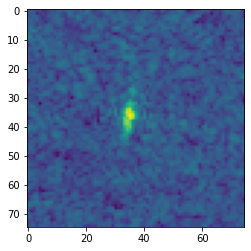

In [16]:
plt.imshow(np.array(ship.iloc[0, 1]).astype(np.float32).reshape(75,75))
plt.show()

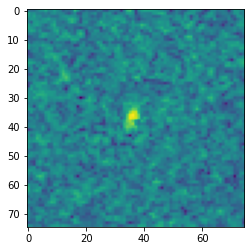

In [17]:
plt.imshow(np.array(iceberg.iloc[0, 1]).astype(np.float32).reshape(75,75))
plt.show()

In [65]:
#import os,shutil
#ship_train_dir = '/content/ship_train'
#ship_validation_dir='/content/ship_validation'
#iceberg_train_dir = '/content/iceberg_train'
#iceberg_validation_dir='/content/iceberg_validation'

In [66]:
#os.mkdir(ship_train_dir) 
#os.mkdir(ship_validation_dir)
#os.mkdir(iceberg_train_dir)
#os.mkdir(iceberg_validation_dir)

In [67]:
#ship=ship.reset_index()
#ship.drop('index', axis=1, inplace=True)
#iceberg=iceberg.reset_index()
#iceberg.drop('index', axis=1, inplace=True)

In [23]:
print(f"ship_index: {len(ship.index)}")
print(f"iceberg_index: {len(iceberg.index)}")

ship_index: 851
iceberg_index: 753


In [24]:
#my_path=os.path.abspath('/content/ship')

In [25]:
#for i in range(0,851):
#    pic=np.array(ship.iloc[i, 1]).astype(np.float32).reshape(75,75)
#    plt.savefig(os.path.join('/content/ship/ship{}.jpg'.format(i)))

In [26]:
#for i in range(0,753):
#    pic=np.array(iceberg.iloc[i, 1]).astype(np.float32).reshape(75,75)
#    plt.savefig(os.path.join('/content/iceberg/{}.jpg'.format(i)))

In [28]:
#from sklearn.model_selection import train_test_split
#
#ship_train, ship_validation=train_test_split(ship, test_size=0.1, random_state=42)

In [30]:
print(f"ship_train_index: {len(ship_train.index)}")
print(f"ship_validation_index: {len(ship_validation.index)}")

ship_train_index: 765
ship_validation_index: 86


In [60]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#np.concatenate해서 새로운 채널을 하나더 만들어주는 것이다 컬러이미지이기 때문에 
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [61]:
Y_train=train['is_iceberg']

In [62]:
Y_train=np.array(Y_train)

In [63]:
print(X_train.shape)
print(X_test.shape)

(1604, 75, 75, 3)
(8424, 75, 75, 3)


# 딥러닝 모델 적용

In [68]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [69]:
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

In [70]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)

In [71]:
y_train=y_train.reshape(-1,1)

In [72]:
y_val=y_val.reshape(-1,1)

In [73]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)

(1443, 75, 75, 3)
(1443, 1)
(161, 75, 75, 3)
(161, 1)
(8424, 75, 75, 3)


#딥러닝 모델 심화

참고자료: https://www.kaggle.com/kishor1210/train-faster-rcnn-using-keras


VGG16 변형
--

In [75]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
print(model.summary())

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

VGG16 응용하여 모델 적용

참고자료: 

https://yazaki.tistory.com/24 (VGG16 & VGG19 구현)


In [80]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)

(1443, 75, 75, 3)
(1443, 1)
(161, 75, 75, 3)
(161, 1)
(8424, 75, 75, 3)


In [84]:
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras import optimizers
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [85]:
model = Sequential()
model.add(Conv2D(input_shape=(75,75,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
#####

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
####
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

####
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())

model.add(Dense(units=512,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

opt=SGD(lr=0.001, momentum=0.9)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [86]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 37, 37, 64)       

In [87]:
# 모델 최적화 설정
# ModelCheckpoint, callback: 각 에포크마다 기록하기
# EarlyStopping: 학습의 자동중단 (val_loss 기준)

MODEL_DIR='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

In [88]:
history=model.fit(x_train, y_train, batch_size=10, epochs=300, validation_data=(x_val,y_val), callbacks=[early_stopping_callback, checkpointer])

Epoch 1/300
145/145 [==============================] - 54s 40ms/step - loss: 0.7651 - acc: 0.6528 - val_loss: 0.7075 - val_acc: 0.4969

Epoch 00001: val_loss improved from inf to 0.70748, saving model to ./model/01-0.7075.hdf5
Epoch 2/300
145/145 [==============================] - 2s 17ms/step - loss: 0.5489 - acc: 0.7330 - val_loss: 0.5621 - val_acc: 0.6894

Epoch 00002: val_loss improved from 0.70748 to 0.56214, saving model to ./model/02-0.5621.hdf5
Epoch 3/300
145/145 [==============================] - 3s 17ms/step - loss: 0.4555 - acc: 0.7872 - val_loss: 0.4675 - val_acc: 0.7764

Epoch 00003: val_loss improved from 0.56214 to 0.46752, saving model to ./model/03-0.4675.hdf5
Epoch 4/300
145/145 [==============================] - 3s 18ms/step - loss: 0.3387 - acc: 0.8494 - val_loss: 0.3157 - val_acc: 0.8447

Epoch 00004: val_loss improved from 0.46752 to 0.31566, saving model to ./model/04-0.3157.hdf5
Epoch 5/300
145/145 [==============================] - 3s 19ms/step - loss: 0.3055 

In [89]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [90]:
print("\n Train Accuracy %.4f"%(model.evaluate(x_train, y_train)[1]))

46/46 [==============================] - 1s 10ms/step - loss: 0.0760 - acc: 0.9841

 Train Accuracy 0.9841


In [91]:
print("\n Test Accuracy %.4f"%(model.evaluate(x_val, y_val)[1]))

6/6 [==============================] - 0s 10ms/step - loss: 0.6370 - acc: 0.8447

 Test Accuracy 0.8447


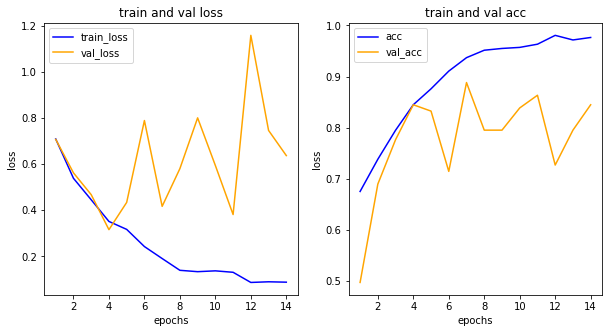

In [92]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

In [93]:
model.save('vgg16_apply.h5')

In [94]:
y_pred=model.predict(X_test)

In [95]:
y_pred_1=pd.DataFrame(y_pred, columns=['is_iceberg'])
sample_submission_1=sample_submission.drop(['is_iceberg'], axis=1)
submission=pd.concat([sample_submission_1, y_pred_1], axis=1)

In [96]:
submission

,id,is_iceberg
0,5941774d,0.000110
1,4023181e,0.984266
2,b20200e4,1.000000
3,e7f018bb,0.968772
4,4371c8c3,0.838000
...,...,...
8419,16ee9b50,0.044481
8420,5a599eb7,0.009679
8421,df30d6dd,0.846843
8422,18af95b1,0.997819


In [97]:
submission.to_csv('submission_4.csv', index=False)

결과:

Score: 0.48368

- 3번째 제출 파일 0.33536에 비해 결과가 안 좋아짐.

VGG19 변형
--

In [98]:
from keras.applications.vgg19 import VGG19
model = VGG19(weights='imagenet')
print(model.summary())

574726144/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [99]:
model = Sequential()
model.add(Conv2D(input_shape=(75,75,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
#####

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
####
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

####
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
####
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())

model.add(Dense(units=512,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

opt=SGD(lr=0.001, momentum=0.9)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [100]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_18 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 37, 37, 64)       

In [101]:
# 모델 최적화 설정
# ModelCheckpoint, callback: 각 에포크마다 기록하기
# EarlyStopping: 학습의 자동중단 (val_loss 기준)

MODEL_DIR='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

In [102]:
history=model.fit(x_train, y_train, batch_size=10, epochs=300, validation_data=(x_val,y_val), callbacks=[early_stopping_callback, checkpointer])

Epoch 1/300
145/145 [==============================] - 11s 33ms/step - loss: 0.8009 - acc: 0.6015 - val_loss: 0.6833 - val_acc: 0.5528

Epoch 00001: val_loss improved from inf to 0.68333, saving model to ./model/01-0.6833.hdf5
Epoch 2/300
145/145 [==============================] - 3s 22ms/step - loss: 0.6001 - acc: 0.7086 - val_loss: 1.2233 - val_acc: 0.4969

Epoch 00002: val_loss did not improve from 0.68333
Epoch 3/300
145/145 [==============================] - 3s 22ms/step - loss: 0.5305 - acc: 0.7442 - val_loss: 0.4435 - val_acc: 0.7516

Epoch 00003: val_loss improved from 0.68333 to 0.44353, saving model to ./model/03-0.4435.hdf5
Epoch 4/300
145/145 [==============================] - 3s 22ms/step - loss: 0.3526 - acc: 0.8511 - val_loss: 0.5244 - val_acc: 0.7826

Epoch 00004: val_loss did not improve from 0.44353
Epoch 5/300
145/145 [==============================] - 3s 22ms/step - loss: 0.3524 - acc: 0.8487 - val_loss: 0.4617 - val_acc: 0.8385

Epoch 00005: val_loss did not improv

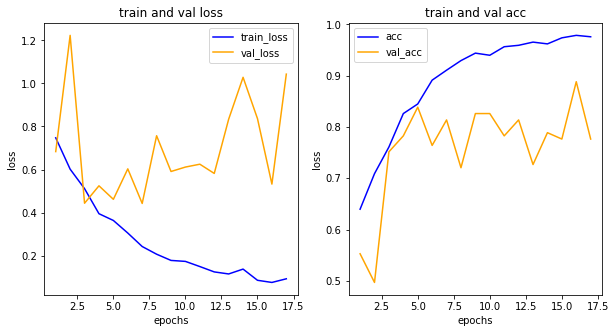

In [107]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

In [103]:
model.save('vgg19_apply.h5')

In [104]:
y_pred=model.predict(X_test)

In [105]:
y_pred_1=pd.DataFrame(y_pred, columns=['is_iceberg'])
sample_submission_1=sample_submission.drop(['is_iceberg'], axis=1)
submission=pd.concat([sample_submission_1, y_pred_1], axis=1)

In [106]:
submission.to_csv('submission_5.csv', index=False)

결과

score: 0.76807 

- 전에 비해 더 안 좋아짐.

VGG16 모델 2번째 변형 (과적합 방지를 위해 Dropout 추가)
--

In [108]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)

(1443, 75, 75, 3)
(1443, 1)
(161, 75, 75, 3)
(161, 1)
(8424, 75, 75, 3)


In [110]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.layers import BatchNormalization
from keras.optimizers import SGD

In [119]:
model = Sequential()
model.add(Conv2D(input_shape=(75,75,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
#####

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
####
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

####
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(units=512,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

opt=SGD(lr=0.001, momentum=0.9)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [120]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_50 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_51 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 37, 37, 64)      

In [121]:
MODEL_DIR='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

In [122]:
history=model.fit(x_train, y_train, batch_size=10, epochs=300, validation_data=(x_val,y_val), callbacks=[early_stopping_callback, checkpointer])

Epoch 1/300
145/145 [==============================] - 11s 26ms/step - loss: 0.8134 - acc: 0.5790 - val_loss: 0.7015 - val_acc: 0.4845

Epoch 00001: val_loss improved from inf to 0.70150, saving model to ./model/01-0.7015.hdf5
Epoch 2/300
145/145 [==============================] - 3s 17ms/step - loss: 0.7375 - acc: 0.6134 - val_loss: 0.7860 - val_acc: 0.5155

Epoch 00002: val_loss did not improve from 0.70150
Epoch 3/300
145/145 [==============================] - 2s 17ms/step - loss: 0.6862 - acc: 0.6638 - val_loss: 0.8140 - val_acc: 0.4845

Epoch 00003: val_loss did not improve from 0.70150
Epoch 4/300
145/145 [==============================] - 3s 18ms/step - loss: 0.6662 - acc: 0.6309 - val_loss: 0.8413 - val_acc: 0.5217

Epoch 00004: val_loss did not improve from 0.70150
Epoch 5/300
145/145 [==============================] - 3s 17ms/step - loss: 0.6083 - acc: 0.6780 - val_loss: 0.9439 - val_acc: 0.5155

Epoch 00005: val_loss did not improve from 0.70150
Epoch 6/300
145/145 [========

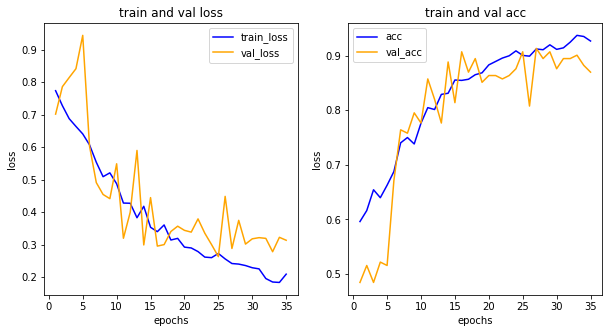

In [123]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

In [124]:
model.save('vgg16_apply_1.h5')

In [125]:
print("\n Train Accuracy %.4f"%(model.evaluate(x_train, y_train)[1]))

46/46 [==============================] - 0s 10ms/step - loss: 0.0964 - acc: 0.9681

 Train Accuracy 0.9681


In [126]:
print("\n Test Accuracy %.4f"%(model.evaluate(x_val, y_val)[1]))

6/6 [==============================] - 0s 10ms/step - loss: 0.3134 - acc: 0.8696

 Test Accuracy 0.8696


In [127]:
y_pred=model.predict(X_test)

In [128]:
y_pred_1=pd.DataFrame(y_pred, columns=['is_iceberg'])
sample_submission_1=sample_submission.drop(['is_iceberg'], axis=1)
submission=pd.concat([sample_submission_1, y_pred_1], axis=1)

In [129]:
submission.to_csv('submission_6.csv', index=False)

결과:

Score: 0.23242

result: 2050등/3330등

- 최고 결과 갱신

VGG19 모델 2번째 변형 (과적합 방지를 위해 Dropout 추가)
--

In [130]:
model = Sequential()
model.add(Conv2D(input_shape=(75,75,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
#####

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
####
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

####
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
####
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.6))
model.add(Flatten())

model.add(Dense(units=512,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

opt=SGD(lr=0.001, momentum=0.9)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [131]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_63 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_64 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 37, 37, 64)      

In [132]:
MODEL_DIR='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

In [133]:
history=model.fit(x_train, y_train, batch_size=10, epochs=300, validation_data=(x_val,y_val), callbacks=[early_stopping_callback, checkpointer])

Epoch 1/300
145/145 [==============================] - 14s 45ms/step - loss: 0.7893 - acc: 0.5786 - val_loss: 0.6918 - val_acc: 0.5155

Epoch 00001: val_loss improved from inf to 0.69179, saving model to ./model/01-0.6918.hdf5
Epoch 2/300
145/145 [==============================] - 3s 22ms/step - loss: 0.7223 - acc: 0.5991 - val_loss: 0.9686 - val_acc: 0.5031

Epoch 00002: val_loss did not improve from 0.69179
Epoch 3/300
145/145 [==============================] - 3s 22ms/step - loss: 0.7652 - acc: 0.5925 - val_loss: 0.8012 - val_acc: 0.5155

Epoch 00003: val_loss did not improve from 0.69179
Epoch 4/300
145/145 [==============================] - 3s 22ms/step - loss: 0.7009 - acc: 0.6254 - val_loss: 0.8395 - val_acc: 0.5963

Epoch 00004: val_loss did not improve from 0.69179
Epoch 5/300
145/145 [==============================] - 3s 22ms/step - loss: 0.6756 - acc: 0.6699 - val_loss: 0.8622 - val_acc: 0.5714

Epoch 00005: val_loss did not improve from 0.69179
Epoch 6/300
145/145 [========

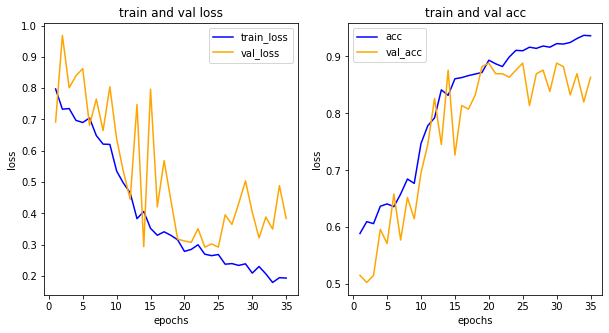

In [134]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

In [135]:
model.save('vgg19_apply_1.h5')

In [136]:
print("\n Train Accuracy %.4f"%(model.evaluate(x_train, y_train)[1]))

46/46 [==============================] - 1s 12ms/step - loss: 0.0788 - acc: 0.9785

 Train Accuracy 0.9785


In [137]:
print("\n Test Accuracy %.4f"%(model.evaluate(x_val, y_val)[1]))

6/6 [==============================] - 0s 11ms/step - loss: 0.3839 - acc: 0.8634

 Test Accuracy 0.8634


In [138]:
y_pred=model.predict(X_test)

In [139]:
y_pred_1=pd.DataFrame(y_pred, columns=['is_iceberg'])
sample_submission_1=sample_submission.drop(['is_iceberg'], axis=1)
submission=pd.concat([sample_submission_1, y_pred_1], axis=1)

In [140]:
submission.to_csv('submission_7.csv', index=False)

결과:

Score: 0.22125

result: 1922등/3330등

- 또 다시 최고 결과 갱신

# band_1, band_2 고유값추출한 뒤 딥러닝 적용

앞서, 빙산분류 1편에서 머신러닝 적용시 각 band_1과 band_2의 고유값을 추출해서 xgboost classifier을 적용하였을 때, 머신러닝 내에서 결과가 가장 좋았던 점을 통해, 고유값을 추출하여, 만든 데이터를 딥러닝에 적용해보고자 한다.

In [141]:
train

,id,band_1,band_2,inc_angle,is_iceberg
0,1413,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,1431,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,566,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,493,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,248,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0
...,...,...,...,...,...
1599,34,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",0.0000,0
1600,1277,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",0.0000,0
1601,1201,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",0.0000,0
1602,813,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",0.0000,0


In [159]:
train_eigen=train.copy()

In [160]:
train_eigen['e_band_1']=0
train_eigen['e_band_2']=0

In [161]:
for i in range(0,1604):
    v=train_eigen[['band_1','band_2']]
    v1=pd.Series(v.iloc[i, 0])
    v2=pd.Series(v.iloc[i, 1])
    v3=pd.concat([v1,v2], axis=1)
    v_cen=v3-v3.mean(axis=0)
    v_cov=np.dot(v_cen.T, v_cen)
    w, v=np.linalg.eig(v_cov)
    train_eigen['e_band_1'][i]=w[0]
    train_eigen['e_band_2'][i]=w[1]
    i+=1

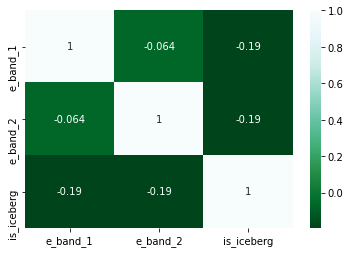

In [163]:
sns.heatmap(data=train_eigen[['e_band_1', 'e_band_2', 'is_iceberg']].corr(), annot=True, cmap='BuGn_r')

In [164]:
from yellowbrick.base import Visualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbedbc8a950>,
                 k=None, metric=None, model=None, timings=True)

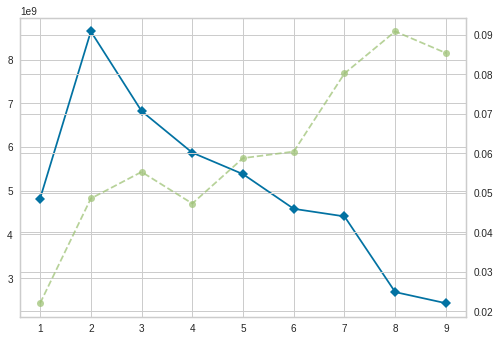

In [165]:
model=KMeans()
visualizer=KElbowVisualizer(model, k=(1,10))
visualizer.fit(np.array(train_eigen['e_band_1']).reshape(-1,1))

- 파란색이 그룹의 변동성을 확인하는 지표이다.

- 녹색 점선은 군집을 학습하는데 걸리는 시간이다.

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbedbd93050>,
                 k=None, metric=None, model=None, timings=True)

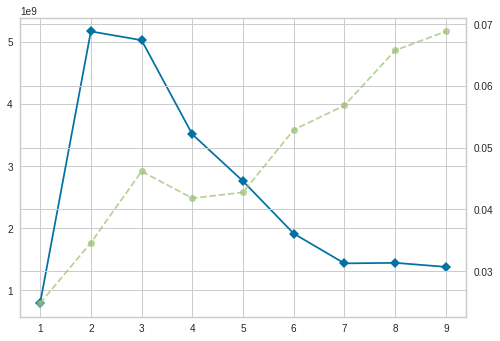

In [166]:
model=KMeans()
visualizer=KElbowVisualizer(model, k=(1,10))
visualizer.fit(np.array(train_eigen['e_band_2']).reshape(-1,1))

In [170]:
kmeans=KMeans(n_clusters=9, random_state=42).fit(train_eigen[['e_band_1','e_band_2']])
clusters=kmeans.predict(train_eigen[['e_band_1','e_band_2']])

train_eigen['clusters']=0
train_eigen['clusters']=clusters

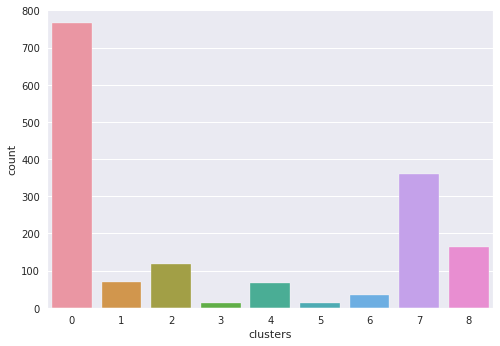

In [173]:
sns.set_style('darkgrid')
sns.countplot(train_eigen['clusters'])

In [171]:
e_train=train_eigen.copy()

In [174]:
e_train=pd.concat([e_train, pd.get_dummies(e_train['clusters'], prefix='clusters')], axis=1)

In [175]:
e_train.drop(['clusters'], axis=1, inplace=True)

In [178]:
e_train.columns

Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg', 'e_band_1',
       'e_band_2', 'clusters_0', 'clusters_1', 'clusters_2', 'clusters_3',
       'clusters_4', 'clusters_5', 'clusters_6', 'clusters_7', 'clusters_8'],
      dtype='object')

In [180]:
e_train=e_train[['id', 'band_1', 'band_2',  'e_band_1',
       'e_band_2', 'clusters_0', 'clusters_1', 'clusters_2', 'clusters_3',
       'clusters_4', 'clusters_5', 'clusters_6', 'clusters_7', 'clusters_8', 'inc_angle', 'is_iceberg']]

In [181]:
e_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1604 non-null   int64  
 1   band_1      1604 non-null   object 
 2   band_2      1604 non-null   object 
 3   e_band_1    1604 non-null   int64  
 4   e_band_2    1604 non-null   int64  
 5   clusters_0  1604 non-null   uint8  
 6   clusters_1  1604 non-null   uint8  
 7   clusters_2  1604 non-null   uint8  
 8   clusters_3  1604 non-null   uint8  
 9   clusters_4  1604 non-null   uint8  
 10  clusters_5  1604 non-null   uint8  
 11  clusters_6  1604 non-null   uint8  
 12  clusters_7  1604 non-null   uint8  
 13  clusters_8  1604 non-null   uint8  
 14  inc_angle   1604 non-null   float64
 15  is_iceberg  1604 non-null   int64  
dtypes: float64(1), int64(4), object(2), uint8(9)
memory usage: 101.9+ KB


In [182]:
test_eigen=test.copy()
sample_submission_eigen=sample_submission.copy()

In [183]:
test_eigen['e_band_1']=0
test_eigen['e_band_2']=0

In [184]:
for i in range(0,8424):
    v=test_eigen[['band_1','band_2']]
    v1=pd.Series(v.iloc[i, 0])
    v2=pd.Series(v.iloc[i, 1])
    v3=pd.concat([v1,v2], axis=1)
    v_cen=v3-v3.mean(axis=0)
    v_cov=np.dot(v_cen.T, v_cen)
    w, v=np.linalg.eig(v_cov)
    test_eigen['e_band_1'][i]=w[0]
    test_eigen['e_band_2'][i]=w[1]
    i+=1

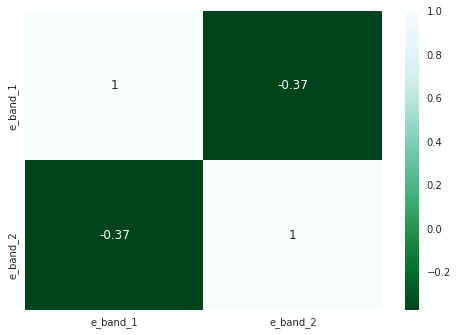

In [185]:
sns.heatmap(data=test_eigen[['e_band_1', 'e_band_2']].corr(), annot=True, cmap='BuGn_r')

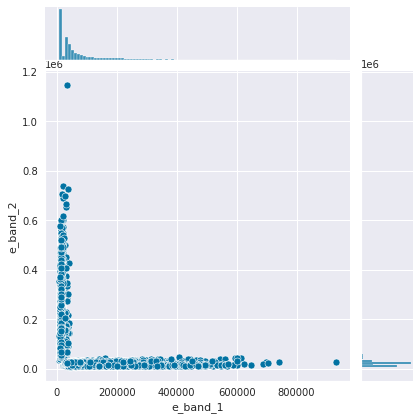

In [186]:
sns.jointplot(data=test_eigen,x='e_band_1', y='e_band_2')

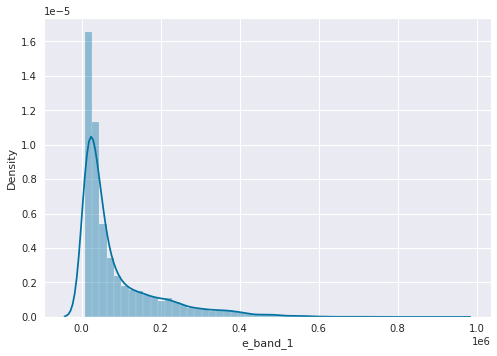

In [187]:
sns.distplot(test_eigen['e_band_1'])

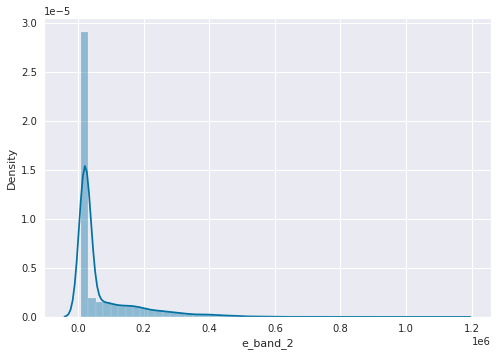

In [188]:
sns.distplot(test_eigen['e_band_2'])

In [190]:
kmeans=KMeans(n_clusters=9, random_state=42).fit(test_eigen[['e_band_1','e_band_2']])
clusters=kmeans.predict(test_eigen[['e_band_1','e_band_2']])

test_eigen['clusters']=0
test_eigen['clusters']=clusters

In [194]:
e_test=test_eigen[['id', 'band_1', 'band_2', 'e_band_1', 'e_band_2',
       'clusters','inc_angle',]]

In [195]:
e_test=pd.concat([e_test, pd.get_dummies(e_test['clusters'], prefix='clusters')], axis=1)
e_test.drop(['clusters'], axis=1, inplace=True)

In [197]:
e_test.columns

Index(['id', 'band_1', 'band_2', 'e_band_1', 'e_band_2', 'inc_angle',
       'clusters_0', 'clusters_1', 'clusters_2', 'clusters_3', 'clusters_4',
       'clusters_5', 'clusters_6', 'clusters_7', 'clusters_8'],
      dtype='object')

In [198]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in e_train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in e_train["band_2"]])
#np.concatenate해서 새로운 채널을 하나더 만들어주는 것이다 컬러이미지이기 때문에 
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in e_test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in e_test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [199]:
Y_train=e_train['is_iceberg']

In [200]:
Y_train=np.array(Y_train)

In [201]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(1604, 75, 75, 3)
(8424, 75, 75, 3)
(1604,)


In [202]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)
y_train=y_train.reshape(-1,1)
y_val=y_val.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)

(1443, 75, 75, 3)
(1443, 1)
(161, 75, 75, 3)
(161, 1)
(8424, 75, 75, 3)


In [203]:
from keras.models import load_model

model=load_model('/content/vgg19_apply_1.h5')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_63 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_64 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 37, 37, 64)      

In [204]:
MODEL_DIR='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

In [205]:
history=model.fit(x_train, y_train, batch_size=10, epochs=300, validation_data=(x_val,y_val), callbacks=[early_stopping_callback, checkpointer])

Epoch 1/300
145/145 [==============================] - 10s 33ms/step - loss: 0.1726 - acc: 0.9439 - val_loss: 0.3979 - val_acc: 0.8696

Epoch 00001: val_loss improved from inf to 0.39788, saving model to ./model/01-0.3979.hdf5
Epoch 2/300
145/145 [==============================] - 3s 22ms/step - loss: 0.1979 - acc: 0.9383 - val_loss: 0.3531 - val_acc: 0.8944

Epoch 00002: val_loss improved from 0.39788 to 0.35312, saving model to ./model/02-0.3531.hdf5
Epoch 3/300
145/145 [==============================] - 3s 22ms/step - loss: 0.1443 - acc: 0.9508 - val_loss: 0.3980 - val_acc: 0.8758

Epoch 00003: val_loss did not improve from 0.35312
Epoch 4/300
145/145 [==============================] - 3s 22ms/step - loss: 0.1568 - acc: 0.9411 - val_loss: 0.3086 - val_acc: 0.8944

Epoch 00004: val_loss improved from 0.35312 to 0.30855, saving model to ./model/04-0.3086.hdf5
Epoch 5/300
145/145 [==============================] - 3s 22ms/step - loss: 0.1580 - acc: 0.9556 - val_loss: 0.4862 - val_acc: 

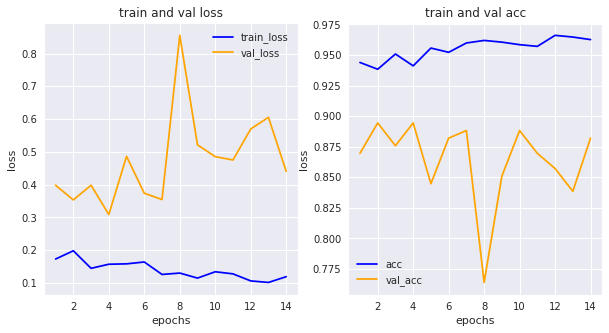

In [206]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

In [207]:
model.save('vgg19_apply_2.h5')

In [208]:
print("\n Train Accuracy %.4f"%(model.evaluate(x_train, y_train)[1]))

46/46 [==============================] - 0s 10ms/step - loss: 0.0189 - acc: 0.9938

 Train Accuracy 0.9938


In [209]:
print("\n Test Accuracy %.4f"%(model.evaluate(x_val, y_val)[1]))

6/6 [==============================] - 0s 10ms/step - loss: 0.4405 - acc: 0.8820

 Test Accuracy 0.8820


In [210]:
y_pred=model.predict(X_test)

In [211]:
y_pred_1=pd.DataFrame(y_pred, columns=['is_iceberg'])
sample_submission_1=sample_submission.drop(['is_iceberg'], axis=1)
submission=pd.concat([sample_submission_1, y_pred_1], axis=1)

In [212]:
submission.to_csv('submission_8.csv', index=False)

결과:

Score: 0.26422

- 오히려 전보다 결과가 안 좋아졌으므로, 여기서 빙산 분류 문제는 마무리 하도록 합니다.

# 최종 결과

가장 좋았던 결과:

Score: 0.22125

Private Leader board result: 1922등/3330등

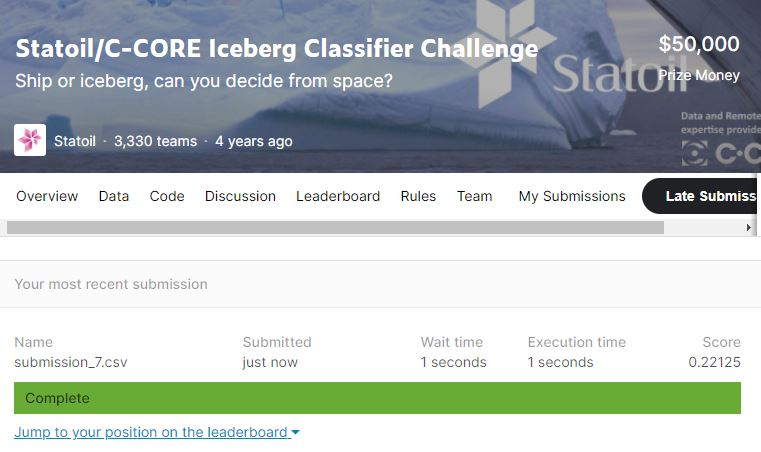

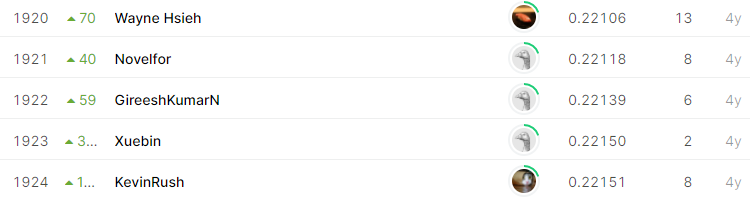